In [1]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=128 # Number of units in the hidden layer of the MLP network
n_layers = 5
input_size = 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-03 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa / np.max(alpha) #Normalization

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta) #Normalization
    
print(bb.shape)

(144, 1)


In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [12]:
hh = hh / np.max(h) #Normalization

In [13]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [14]:
baseline_coord = data.iloc[:,:].values

In [15]:
standard_coord = baseline_coord.reshape((1, -1))

In [16]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [17]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [18]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [19]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [20]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [21]:
x = np.hstack((aa, hh, bb))

In [22]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [23]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [24]:
target_c3 = target_df.iloc[:,4].values # Cl values

In [25]:
cl = target_c3.reshape((-1,1))

In [26]:
y = (cl-np.min(cl))/(np.max(cl)-np.min(cl))

In [27]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [28]:
x_train, x_val, x_test, y_train, y_val, y_test, cd_train, cd_val, cd_test = dataset_split(x, y, cl,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [29]:
x_train.shape

(100, 3)

In [30]:
y_train.shape

(100, 1)

In [31]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=3)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer)(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [32]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 fc1 (Dense)                 (None, 128)               512       
                                                                 
 fc2 (Dense)                 (None, 128)               16512     
                                                                 
 fc3 (Dense)                 (None, 128)               16512     
                                                                 
 fc4 (Dense)                 (None, 128)               16512     
                                                                 
 fc5 (Dense)                 (None, 128)               16512     
                                                                 
 outputLayer (Dense)         (None, 1)                 129   

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [34]:
model_directory = "D:\\TrainedModels\\20221230\\steady_previousSetting"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [35]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000, min_delta=1e-06,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=500, factor=0.1,
                                          min_delta = 1e-6, min_lr=1e-08, verbose=1)

In [36]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [37]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/10000
5/5 [==============================] - 5s 101ms/step - loss: 0.2440 - rmse: 0.4939 - val_loss: 0.0735 - val_rmse: 0.2712 - lr: 0.0010
Epoch 2/10000
5/5 [==============================] - 0s 16ms/step - loss: 0.0494 - rmse: 0.2223 - val_loss: 0.0806 - val_rmse: 0.2840 - lr: 0.0010
Epoch 3/10000
5/5 [==============================] - 0s 15ms/step - loss: 0.0409 - rmse: 0.2021 - val_loss: 0.0444 - val_rmse: 0.2108 - lr: 0.0010
Epoch 4/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0262 - rmse: 0.1618 - val_loss: 0.0330 - val_rmse: 0.1818 - lr: 0.0010
Epoch 5/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0141 - rmse: 0.1189 - val_loss: 0.0364 - val_rmse: 0.1909 - lr: 0.0010
Epoch 6/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0135 - rmse: 0.1160 - val_loss: 0.0254 - val_rmse: 0.1595 - lr: 0.0010
Epoch 7/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0112 - rmse: 0.1060 - val_loss: 0.0242 - 

5/5 [==============================] - 0s 13ms/step - loss: 0.0039 - rmse: 0.0627 - val_loss: 0.0138 - val_rmse: 0.1173 - lr: 0.0010
Epoch 57/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0034 - rmse: 0.0581 - val_loss: 0.0128 - val_rmse: 0.1132 - lr: 0.0010
Epoch 58/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.0037 - rmse: 0.0608 - val_loss: 0.0148 - val_rmse: 0.1216 - lr: 0.0010
Epoch 59/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.0032 - rmse: 0.0564 - val_loss: 0.0133 - val_rmse: 0.1154 - lr: 0.0010
Epoch 60/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0029 - rmse: 0.0540 - val_loss: 0.0121 - val_rmse: 0.1101 - lr: 0.0010
Epoch 61/10000
5/5 [==============================] - 0s 12ms/step - loss: 0.0030 - rmse: 0.0549 - val_loss: 0.0126 - val_rmse: 0.1122 - lr: 0.0010
Epoch 62/10000
5/5 [==============================] - 0s 13ms/step - loss: 0.0026 - rmse: 0.0512 - val_loss: 0.0101 - val_rmse:

5/5 [==============================] - 0s 12ms/step - loss: 2.0610e-04 - rmse: 0.0144 - val_loss: 0.0024 - val_rmse: 0.0488 - lr: 0.0010
Epoch 111/10000
5/5 [==============================] - 0s 13ms/step - loss: 2.3226e-04 - rmse: 0.0152 - val_loss: 0.0010 - val_rmse: 0.0319 - lr: 0.0010
Epoch 112/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.7207e-04 - rmse: 0.0131 - val_loss: 0.0018 - val_rmse: 0.0430 - lr: 0.0010
Epoch 113/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.2124e-04 - rmse: 0.0110 - val_loss: 0.0011 - val_rmse: 0.0336 - lr: 0.0010
Epoch 114/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.4467e-04 - rmse: 0.0120 - val_loss: 0.0016 - val_rmse: 0.0406 - lr: 0.0010
Epoch 115/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.0158e-04 - rmse: 0.0101 - val_loss: 0.0013 - val_rmse: 0.0361 - lr: 0.0010
Epoch 116/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.0519e-04 - rmse: 0.0

5/5 [==============================] - 0s 12ms/step - loss: 5.5804e-05 - rmse: 0.0075 - val_loss: 0.0013 - val_rmse: 0.0356 - lr: 0.0010
Epoch 164/10000
5/5 [==============================] - 0s 12ms/step - loss: 7.0976e-05 - rmse: 0.0084 - val_loss: 0.0010 - val_rmse: 0.0317 - lr: 0.0010
Epoch 165/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.3018e-04 - rmse: 0.0114 - val_loss: 0.0013 - val_rmse: 0.0366 - lr: 0.0010
Epoch 166/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.1505e-04 - rmse: 0.0107 - val_loss: 0.0012 - val_rmse: 0.0350 - lr: 0.0010
Epoch 167/10000
5/5 [==============================] - 0s 12ms/step - loss: 8.6407e-05 - rmse: 0.0093 - val_loss: 0.0015 - val_rmse: 0.0385 - lr: 0.0010
Epoch 168/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.2994e-04 - rmse: 0.0114 - val_loss: 0.0015 - val_rmse: 0.0384 - lr: 0.0010
Epoch 169/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.0667e-04 - rmse: 0.0

5/5 [==============================] - 0s 13ms/step - loss: 5.2338e-05 - rmse: 0.0072 - val_loss: 9.4376e-04 - val_rmse: 0.0307 - lr: 0.0010
Epoch 217/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.8189e-05 - rmse: 0.0062 - val_loss: 9.4323e-04 - val_rmse: 0.0307 - lr: 0.0010
Epoch 218/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.5251e-05 - rmse: 0.0050 - val_loss: 0.0011 - val_rmse: 0.0336 - lr: 0.0010
Epoch 219/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.8831e-05 - rmse: 0.0054 - val_loss: 0.0011 - val_rmse: 0.0330 - lr: 0.0010
Epoch 220/10000
5/5 [==============================] - 0s 12ms/step - loss: 5.4967e-05 - rmse: 0.0074 - val_loss: 0.0012 - val_rmse: 0.0346 - lr: 0.0010
Epoch 221/10000
5/5 [==============================] - 0s 12ms/step - loss: 7.9710e-05 - rmse: 0.0089 - val_loss: 0.0010 - val_rmse: 0.0317 - lr: 0.0010
Epoch 222/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.4141e-04 - r

Epoch 269/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.7564e-05 - rmse: 0.0053 - val_loss: 7.9018e-04 - val_rmse: 0.0281 - lr: 0.0010
Epoch 270/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.0521e-05 - rmse: 0.0045 - val_loss: 0.0012 - val_rmse: 0.0344 - lr: 0.0010
Epoch 271/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.0875e-05 - rmse: 0.0056 - val_loss: 7.6019e-04 - val_rmse: 0.0276 - lr: 0.0010
Epoch 272/10000
5/5 [==============================] - 0s 12ms/step - loss: 6.3525e-05 - rmse: 0.0080 - val_loss: 0.0020 - val_rmse: 0.0446 - lr: 0.0010
Epoch 273/10000
5/5 [==============================] - 0s 13ms/step - loss: 9.3859e-05 - rmse: 0.0097 - val_loss: 6.7465e-04 - val_rmse: 0.0260 - lr: 0.0010
Epoch 274/10000
5/5 [==============================] - 0s 12ms/step - loss: 7.0967e-05 - rmse: 0.0084 - val_loss: 9.9580e-04 - val_rmse: 0.0316 - lr: 0.0010
Epoch 275/10000
5/5 [==============================] - 0s 13ms/ste

5/5 [==============================] - 0s 12ms/step - loss: 1.0975e-05 - rmse: 0.0033 - val_loss: 7.5244e-04 - val_rmse: 0.0274 - lr: 0.0010
Epoch 322/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.3890e-05 - rmse: 0.0037 - val_loss: 7.4390e-04 - val_rmse: 0.0273 - lr: 0.0010
Epoch 323/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.2774e-05 - rmse: 0.0036 - val_loss: 7.5212e-04 - val_rmse: 0.0274 - lr: 0.0010
Epoch 324/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.3791e-05 - rmse: 0.0037 - val_loss: 7.9136e-04 - val_rmse: 0.0281 - lr: 0.0010
Epoch 325/10000
5/5 [==============================] - 0s 12ms/step - loss: 7.0939e-06 - rmse: 0.0027 - val_loss: 6.5801e-04 - val_rmse: 0.0257 - lr: 0.0010
Epoch 326/10000
5/5 [==============================] - 0s 12ms/step - loss: 7.2248e-06 - rmse: 0.0027 - val_loss: 7.6544e-04 - val_rmse: 0.0277 - lr: 0.0010
Epoch 327/10000
5/5 [==============================] - 0s 12ms/step - loss

5/5 [==============================] - 0s 13ms/step - loss: 7.9399e-05 - rmse: 0.0089 - val_loss: 4.7285e-04 - val_rmse: 0.0217 - lr: 0.0010
Epoch 374/10000
5/5 [==============================] - 0s 13ms/step - loss: 7.8901e-05 - rmse: 0.0089 - val_loss: 4.6993e-04 - val_rmse: 0.0217 - lr: 0.0010
Epoch 375/10000
5/5 [==============================] - 0s 12ms/step - loss: 7.2696e-05 - rmse: 0.0085 - val_loss: 0.0014 - val_rmse: 0.0370 - lr: 0.0010
Epoch 376/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.6420e-04 - rmse: 0.0128 - val_loss: 9.6233e-04 - val_rmse: 0.0310 - lr: 0.0010
Epoch 377/10000
5/5 [==============================] - 0s 12ms/step - loss: 8.0137e-05 - rmse: 0.0090 - val_loss: 6.9213e-04 - val_rmse: 0.0263 - lr: 0.0010
Epoch 378/10000
5/5 [==============================] - 0s 12ms/step - loss: 9.7167e-05 - rmse: 0.0099 - val_loss: 0.0011 - val_rmse: 0.0331 - lr: 0.0010
Epoch 379/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.6648

Epoch 427/10000
5/5 [==============================] - 0s 12ms/step - loss: 8.9572e-05 - rmse: 0.0095 - val_loss: 9.5358e-04 - val_rmse: 0.0309 - lr: 0.0010
Epoch 428/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.2226e-04 - rmse: 0.0111 - val_loss: 8.0175e-04 - val_rmse: 0.0283 - lr: 0.0010
Epoch 429/10000
5/5 [==============================] - 0s 12ms/step - loss: 6.1029e-05 - rmse: 0.0078 - val_loss: 7.6910e-04 - val_rmse: 0.0277 - lr: 0.0010
Epoch 430/10000
5/5 [==============================] - 0s 12ms/step - loss: 5.8982e-05 - rmse: 0.0077 - val_loss: 7.8868e-04 - val_rmse: 0.0281 - lr: 0.0010
Epoch 431/10000
5/5 [==============================] - 0s 12ms/step - loss: 4.8648e-05 - rmse: 0.0070 - val_loss: 7.2244e-04 - val_rmse: 0.0269 - lr: 0.0010
Epoch 432/10000
5/5 [==============================] - 0s 12ms/step - loss: 4.9491e-05 - rmse: 0.0070 - val_loss: 7.8035e-04 - val_rmse: 0.0279 - lr: 0.0010
Epoch 433/10000
5/5 [==============================] - 0s 

5/5 [==============================] - 0s 12ms/step - loss: 1.4760e-05 - rmse: 0.0038 - val_loss: 7.6348e-04 - val_rmse: 0.0276 - lr: 0.0010
Epoch 480/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.5132e-05 - rmse: 0.0039 - val_loss: 6.4953e-04 - val_rmse: 0.0255 - lr: 0.0010
Epoch 481/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.4846e-05 - rmse: 0.0039 - val_loss: 7.1618e-04 - val_rmse: 0.0268 - lr: 0.0010
Epoch 482/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.5476e-05 - rmse: 0.0039 - val_loss: 7.3649e-04 - val_rmse: 0.0271 - lr: 0.0010
Epoch 483/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.1292e-05 - rmse: 0.0046 - val_loss: 7.0648e-04 - val_rmse: 0.0266 - lr: 0.0010
Epoch 484/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.3976e-05 - rmse: 0.0037 - val_loss: 6.8954e-04 - val_rmse: 0.0263 - lr: 0.0010
Epoch 485/10000
5/5 [==============================] - 0s 12ms/step - loss

5/5 [==============================] - 0s 12ms/step - loss: 7.4558e-06 - rmse: 0.0027 - val_loss: 7.3728e-04 - val_rmse: 0.0272 - lr: 0.0010
Epoch 532/10000
5/5 [==============================] - 0s 12ms/step - loss: 5.7547e-06 - rmse: 0.0024 - val_loss: 7.2259e-04 - val_rmse: 0.0269 - lr: 0.0010
Epoch 533/10000
5/5 [==============================] - 0s 12ms/step - loss: 4.9103e-06 - rmse: 0.0022 - val_loss: 7.3291e-04 - val_rmse: 0.0271 - lr: 0.0010
Epoch 534/10000
5/5 [==============================] - 0s 12ms/step - loss: 4.4299e-06 - rmse: 0.0021 - val_loss: 6.9659e-04 - val_rmse: 0.0264 - lr: 0.0010
Epoch 535/10000
5/5 [==============================] - 0s 12ms/step - loss: 4.3950e-06 - rmse: 0.0021 - val_loss: 7.2977e-04 - val_rmse: 0.0270 - lr: 0.0010
Epoch 536/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.9866e-06 - rmse: 0.0020 - val_loss: 7.2958e-04 - val_rmse: 0.0270 - lr: 0.0010
Epoch 537/10000
5/5 [==============================] - 0s 12ms/step - loss

5/5 [==============================] - 0s 12ms/step - loss: 4.3916e-06 - rmse: 0.0021 - val_loss: 6.8694e-04 - val_rmse: 0.0262 - lr: 0.0010
Epoch 584/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.4470e-06 - rmse: 0.0019 - val_loss: 7.1813e-04 - val_rmse: 0.0268 - lr: 0.0010
Epoch 585/10000
5/5 [==============================] - 0s 12ms/step - loss: 7.8206e-06 - rmse: 0.0028 - val_loss: 6.6782e-04 - val_rmse: 0.0258 - lr: 0.0010
Epoch 586/10000
5/5 [==============================] - 0s 12ms/step - loss: 8.8848e-06 - rmse: 0.0030 - val_loss: 6.7584e-04 - val_rmse: 0.0260 - lr: 0.0010
Epoch 587/10000
5/5 [==============================] - 0s 12ms/step - loss: 6.1353e-06 - rmse: 0.0025 - val_loss: 6.6921e-04 - val_rmse: 0.0259 - lr: 0.0010
Epoch 588/10000
5/5 [==============================] - 0s 13ms/step - loss: 3.6172e-06 - rmse: 0.0019 - val_loss: 7.2057e-04 - val_rmse: 0.0268 - lr: 0.0010
Epoch 589/10000
5/5 [==============================] - 0s 13ms/step - loss

5/5 [==============================] - 0s 12ms/step - loss: 3.7544e-06 - rmse: 0.0019 - val_loss: 7.9721e-04 - val_rmse: 0.0282 - lr: 0.0010
Epoch 636/10000
5/5 [==============================] - 0s 12ms/step - loss: 4.8303e-06 - rmse: 0.0022 - val_loss: 6.4867e-04 - val_rmse: 0.0255 - lr: 0.0010
Epoch 637/10000
5/5 [==============================] - 0s 12ms/step - loss: 5.2120e-06 - rmse: 0.0023 - val_loss: 7.0541e-04 - val_rmse: 0.0266 - lr: 0.0010
Epoch 638/10000
5/5 [==============================] - 0s 12ms/step - loss: 5.6201e-06 - rmse: 0.0024 - val_loss: 6.1539e-04 - val_rmse: 0.0248 - lr: 0.0010
Epoch 639/10000
5/5 [==============================] - 0s 12ms/step - loss: 5.2289e-06 - rmse: 0.0023 - val_loss: 7.2809e-04 - val_rmse: 0.0270 - lr: 0.0010
Epoch 640/10000
5/5 [==============================] - 0s 12ms/step - loss: 7.0817e-06 - rmse: 0.0027 - val_loss: 6.9227e-04 - val_rmse: 0.0263 - lr: 0.0010
Epoch 641/10000
5/5 [==============================] - 0s 12ms/step - loss

5/5 [==============================] - 0s 12ms/step - loss: 1.1319e-04 - rmse: 0.0106 - val_loss: 9.7155e-04 - val_rmse: 0.0312 - lr: 0.0010
Epoch 688/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.4247e-04 - rmse: 0.0156 - val_loss: 0.0018 - val_rmse: 0.0419 - lr: 0.0010
Epoch 689/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.0668e-04 - rmse: 0.0175 - val_loss: 6.5244e-04 - val_rmse: 0.0255 - lr: 0.0010
Epoch 690/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.7229e-04 - rmse: 0.0165 - val_loss: 0.0018 - val_rmse: 0.0421 - lr: 0.0010
Epoch 691/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.2024e-04 - rmse: 0.0179 - val_loss: 5.8711e-04 - val_rmse: 0.0242 - lr: 0.0010
Epoch 692/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.2374e-04 - rmse: 0.0180 - val_loss: 0.0017 - val_rmse: 0.0415 - lr: 0.0010
Epoch 693/10000
5/5 [==============================] - 0s 12ms/step - loss: 6.3397e-04

5/5 [==============================] - 0s 12ms/step - loss: 6.4077e-06 - rmse: 0.0025 - val_loss: 4.2558e-04 - val_rmse: 0.0206 - lr: 0.0010
Epoch 740/10000
5/5 [==============================] - 0s 11ms/step - loss: 7.4130e-06 - rmse: 0.0027 - val_loss: 4.9842e-04 - val_rmse: 0.0223 - lr: 0.0010
Epoch 741/10000
5/5 [==============================] - 0s 12ms/step - loss: 5.5165e-06 - rmse: 0.0023 - val_loss: 4.3044e-04 - val_rmse: 0.0207 - lr: 0.0010
Epoch 742/10000
5/5 [==============================] - 0s 12ms/step - loss: 6.9184e-06 - rmse: 0.0026 - val_loss: 4.6967e-04 - val_rmse: 0.0217 - lr: 0.0010
Epoch 743/10000
5/5 [==============================] - 0s 12ms/step - loss: 5.6113e-06 - rmse: 0.0024 - val_loss: 4.3474e-04 - val_rmse: 0.0209 - lr: 0.0010
Epoch 744/10000
5/5 [==============================] - 0s 12ms/step - loss: 4.1519e-06 - rmse: 0.0020 - val_loss: 4.6607e-04 - val_rmse: 0.0216 - lr: 0.0010
Epoch 745/10000
5/5 [==============================] - 0s 12ms/step - loss

5/5 [==============================] - 0s 12ms/step - loss: 2.6844e-06 - rmse: 0.0016 - val_loss: 4.5699e-04 - val_rmse: 0.0214 - lr: 0.0010
Epoch 792/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.9014e-06 - rmse: 0.0014 - val_loss: 4.2276e-04 - val_rmse: 0.0206 - lr: 0.0010
Epoch 793/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.1454e-06 - rmse: 0.0015 - val_loss: 4.6196e-04 - val_rmse: 0.0215 - lr: 0.0010
Epoch 794/10000
5/5 [==============================] - 0s 13ms/step - loss: 2.6134e-06 - rmse: 0.0016 - val_loss: 4.3946e-04 - val_rmse: 0.0210 - lr: 0.0010
Epoch 795/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.4334e-06 - rmse: 0.0016 - val_loss: 4.5500e-04 - val_rmse: 0.0213 - lr: 0.0010
Epoch 796/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.0161e-06 - rmse: 0.0017 - val_loss: 4.5082e-04 - val_rmse: 0.0212 - lr: 0.0010
Epoch 797/10000
5/5 [==============================] - 0s 12ms/step - loss

5/5 [==============================] - 0s 11ms/step - loss: 3.3533e-06 - rmse: 0.0018 - val_loss: 4.3157e-04 - val_rmse: 0.0208 - lr: 0.0010
Epoch 844/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.6638e-06 - rmse: 0.0013 - val_loss: 4.2412e-04 - val_rmse: 0.0206 - lr: 0.0010
Epoch 845/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.5044e-06 - rmse: 0.0016 - val_loss: 4.7221e-04 - val_rmse: 0.0217 - lr: 0.0010
Epoch 846/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.7338e-06 - rmse: 0.0013 - val_loss: 4.2648e-04 - val_rmse: 0.0207 - lr: 0.0010
Epoch 847/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.3354e-06 - rmse: 0.0015 - val_loss: 4.5751e-04 - val_rmse: 0.0214 - lr: 0.0010
Epoch 848/10000
5/5 [==============================] - 0s 11ms/step - loss: 3.5104e-06 - rmse: 0.0019 - val_loss: 4.2757e-04 - val_rmse: 0.0207 - lr: 0.0010
Epoch 849/10000
5/5 [==============================] - 0s 11ms/step - loss

Epoch 896/10000
5/5 [==============================] - 0s 11ms/step - loss: 4.4536e-05 - rmse: 0.0067 - val_loss: 7.2683e-04 - val_rmse: 0.0270 - lr: 0.0010
Epoch 897/10000
5/5 [==============================] - 0s 11ms/step - loss: 4.6066e-05 - rmse: 0.0068 - val_loss: 7.6179e-04 - val_rmse: 0.0276 - lr: 0.0010
Epoch 898/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.8525e-05 - rmse: 0.0062 - val_loss: 7.2772e-04 - val_rmse: 0.0270 - lr: 0.0010
Epoch 899/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.7393e-05 - rmse: 0.0061 - val_loss: 6.6273e-04 - val_rmse: 0.0257 - lr: 0.0010
Epoch 900/10000
5/5 [==============================] - 0s 11ms/step - loss: 3.7117e-05 - rmse: 0.0061 - val_loss: 6.5453e-04 - val_rmse: 0.0256 - lr: 0.0010
Epoch 901/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.7245e-05 - rmse: 0.0052 - val_loss: 6.6463e-04 - val_rmse: 0.0258 - lr: 0.0010
Epoch 902/10000
5/5 [==============================] - 0s 

5/5 [==============================] - 0s 11ms/step - loss: 1.5397e-04 - rmse: 0.0124 - val_loss: 0.0010 - val_rmse: 0.0322 - lr: 0.0010
Epoch 949/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.7316e-04 - rmse: 0.0132 - val_loss: 7.9215e-04 - val_rmse: 0.0281 - lr: 0.0010
Epoch 950/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.0145e-04 - rmse: 0.0101 - val_loss: 7.7134e-04 - val_rmse: 0.0278 - lr: 0.0010
Epoch 951/10000
5/5 [==============================] - 0s 12ms/step - loss: 6.0750e-05 - rmse: 0.0078 - val_loss: 3.9017e-04 - val_rmse: 0.0198 - lr: 0.0010
Epoch 952/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.0477e-04 - rmse: 0.0102 - val_loss: 5.2473e-04 - val_rmse: 0.0229 - lr: 0.0010
Epoch 953/10000
5/5 [==============================] - 0s 12ms/step - loss: 7.6585e-05 - rmse: 0.0088 - val_loss: 5.6118e-04 - val_rmse: 0.0237 - lr: 0.0010
Epoch 954/10000
5/5 [==============================] - 0s 12ms/step - loss: 6.

5/5 [==============================] - 0s 12ms/step - loss: 4.9236e-06 - rmse: 0.0022 - val_loss: 5.7900e-04 - val_rmse: 0.0241 - lr: 0.0010
Epoch 1001/10000
5/5 [==============================] - 0s 12ms/step - loss: 6.1983e-06 - rmse: 0.0025 - val_loss: 5.7585e-04 - val_rmse: 0.0240 - lr: 0.0010
Epoch 1002/10000
5/5 [==============================] - 0s 11ms/step - loss: 5.4554e-06 - rmse: 0.0023 - val_loss: 5.7832e-04 - val_rmse: 0.0240 - lr: 0.0010
Epoch 1003/10000
5/5 [==============================] - 0s 12ms/step - loss: 4.8985e-06 - rmse: 0.0022 - val_loss: 5.8686e-04 - val_rmse: 0.0242 - lr: 0.0010
Epoch 1004/10000
5/5 [==============================] - 0s 11ms/step - loss: 4.8574e-06 - rmse: 0.0022 - val_loss: 5.9205e-04 - val_rmse: 0.0243 - lr: 0.0010
Epoch 1005/10000
5/5 [==============================] - 0s 12ms/step - loss: 4.0834e-06 - rmse: 0.0020 - val_loss: 6.1187e-04 - val_rmse: 0.0247 - lr: 0.0010
Epoch 1006/10000
5/5 [==============================] - 0s 12ms/step 

Epoch 1052/10000
5/5 [==============================] - 0s 11ms/step - loss: 2.8009e-05 - rmse: 0.0053 - val_loss: 5.3344e-04 - val_rmse: 0.0231 - lr: 0.0010
Epoch 1053/10000
5/5 [==============================] - 0s 11ms/step - loss: 3.0249e-05 - rmse: 0.0055 - val_loss: 5.0746e-04 - val_rmse: 0.0225 - lr: 0.0010
Epoch 1054/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.1360e-05 - rmse: 0.0046 - val_loss: 6.2762e-04 - val_rmse: 0.0251 - lr: 0.0010
Epoch 1055/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.2767e-05 - rmse: 0.0048 - val_loss: 5.1471e-04 - val_rmse: 0.0227 - lr: 0.0010
Epoch 1056/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.0553e-05 - rmse: 0.0032 - val_loss: 5.0365e-04 - val_rmse: 0.0224 - lr: 0.0010
Epoch 1057/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.3732e-05 - rmse: 0.0037 - val_loss: 5.1022e-04 - val_rmse: 0.0226 - lr: 0.0010
Epoch 1058/10000
5/5 [==============================

Epoch 1104/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.3147e-05 - rmse: 0.0036 - val_loss: 5.0073e-04 - val_rmse: 0.0224 - lr: 0.0010
Epoch 1105/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.4241e-05 - rmse: 0.0038 - val_loss: 5.3534e-04 - val_rmse: 0.0231 - lr: 0.0010
Epoch 1106/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.7465e-05 - rmse: 0.0052 - val_loss: 5.0228e-04 - val_rmse: 0.0224 - lr: 0.0010
Epoch 1107/10000
5/5 [==============================] - 0s 11ms/step - loss: 2.8853e-05 - rmse: 0.0054 - val_loss: 5.7873e-04 - val_rmse: 0.0241 - lr: 0.0010
Epoch 1108/10000
5/5 [==============================] - 0s 11ms/step - loss: 2.2277e-05 - rmse: 0.0047 - val_loss: 5.9072e-04 - val_rmse: 0.0243 - lr: 0.0010
Epoch 1109/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.5063e-05 - rmse: 0.0039 - val_loss: 5.4122e-04 - val_rmse: 0.0233 - lr: 0.0010
Epoch 1110/10000
5/5 [==============================

Epoch 1156/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.7323e-05 - rmse: 0.0042 - val_loss: 5.5801e-04 - val_rmse: 0.0236 - lr: 0.0010
Epoch 1157/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.9290e-05 - rmse: 0.0044 - val_loss: 5.7250e-04 - val_rmse: 0.0239 - lr: 0.0010
Epoch 1158/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.0885e-05 - rmse: 0.0033 - val_loss: 6.2514e-04 - val_rmse: 0.0250 - lr: 0.0010
Epoch 1159/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.5429e-05 - rmse: 0.0039 - val_loss: 6.0517e-04 - val_rmse: 0.0246 - lr: 0.0010
Epoch 1160/10000
5/5 [==============================] - 0s 12ms/step - loss: 8.1421e-06 - rmse: 0.0029 - val_loss: 5.2973e-04 - val_rmse: 0.0230 - lr: 0.0010
Epoch 1161/10000
5/5 [==============================] - 0s 12ms/step - loss: 5.3505e-06 - rmse: 0.0023 - val_loss: 5.4683e-04 - val_rmse: 0.0234 - lr: 0.0010
Epoch 1162/10000
5/5 [==============================

Epoch 1208/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.8588e-05 - rmse: 0.0043 - val_loss: 5.2904e-04 - val_rmse: 0.0230 - lr: 0.0010
Epoch 1209/10000
5/5 [==============================] - 0s 12ms/step - loss: 4.5067e-05 - rmse: 0.0067 - val_loss: 5.1930e-04 - val_rmse: 0.0228 - lr: 0.0010
Epoch 1210/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.6564e-05 - rmse: 0.0052 - val_loss: 5.0607e-04 - val_rmse: 0.0225 - lr: 0.0010
Epoch 1211/10000
5/5 [==============================] - 0s 12ms/step - loss: 9.3998e-06 - rmse: 0.0031 - val_loss: 5.6737e-04 - val_rmse: 0.0238 - lr: 0.0010
Epoch 1212/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.2099e-05 - rmse: 0.0035 - val_loss: 5.1653e-04 - val_rmse: 0.0227 - lr: 0.0010
Epoch 1213/10000
5/5 [==============================] - 0s 13ms/step - loss: 1.9302e-05 - rmse: 0.0044 - val_loss: 6.8461e-04 - val_rmse: 0.0262 - lr: 0.0010
Epoch 1214/10000
5/5 [==============================

Epoch 1261/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.0060e-04 - rmse: 0.0100 - val_loss: 5.8363e-04 - val_rmse: 0.0242 - lr: 0.0010
Epoch 1262/10000
5/5 [==============================] - 0s 11ms/step - loss: 9.3836e-05 - rmse: 0.0097 - val_loss: 4.9273e-04 - val_rmse: 0.0222 - lr: 0.0010
Epoch 1263/10000
5/5 [==============================] - 0s 11ms/step - loss: 7.5876e-05 - rmse: 0.0087 - val_loss: 5.6333e-04 - val_rmse: 0.0237 - lr: 0.0010
Epoch 1264/10000
5/5 [==============================] - 0s 11ms/step - loss: 8.5695e-05 - rmse: 0.0093 - val_loss: 5.9312e-04 - val_rmse: 0.0244 - lr: 0.0010
Epoch 1265/10000
5/5 [==============================] - 0s 12ms/step - loss: 5.5369e-05 - rmse: 0.0074 - val_loss: 5.8173e-04 - val_rmse: 0.0241 - lr: 0.0010
Epoch 1266/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.4141e-05 - rmse: 0.0049 - val_loss: 4.8954e-04 - val_rmse: 0.0221 - lr: 0.0010
Epoch 1267/10000
5/5 [==============================

Epoch 1313/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.1066e-06 - rmse: 0.0015 - val_loss: 4.0420e-04 - val_rmse: 0.0201 - lr: 0.0010
Epoch 1314/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.3702e-06 - rmse: 0.0015 - val_loss: 4.0326e-04 - val_rmse: 0.0201 - lr: 0.0010
Epoch 1315/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.3798e-06 - rmse: 0.0015 - val_loss: 4.1051e-04 - val_rmse: 0.0203 - lr: 0.0010
Epoch 1316/10000
5/5 [==============================] - 0s 11ms/step - loss: 2.5733e-06 - rmse: 0.0016 - val_loss: 4.0543e-04 - val_rmse: 0.0201 - lr: 0.0010
Epoch 1317/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.7893e-06 - rmse: 0.0013 - val_loss: 4.1099e-04 - val_rmse: 0.0203 - lr: 0.0010
Epoch 1318/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.2217e-06 - rmse: 0.0015 - val_loss: 4.0680e-04 - val_rmse: 0.0202 - lr: 0.0010
Epoch 1319/10000
5/5 [==============================

5/5 [==============================] - 0s 12ms/step - loss: 5.6959e-07 - rmse: 7.5471e-04 - val_loss: 3.9229e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 1364/10000
5/5 [==============================] - 0s 13ms/step - loss: 5.7135e-07 - rmse: 7.5587e-04 - val_loss: 3.9394e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 1365/10000
5/5 [==============================] - 0s 13ms/step - loss: 5.5322e-07 - rmse: 7.4379e-04 - val_loss: 3.9345e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 1366/10000
5/5 [==============================] - 0s 13ms/step - loss: 5.5086e-07 - rmse: 7.4220e-04 - val_loss: 3.9339e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 1367/10000
5/5 [==============================] - 0s 18ms/step - loss: 5.2888e-07 - rmse: 7.2724e-04 - val_loss: 3.9413e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1368/10000
5/5 [==============================] - 0s 18ms/step - loss: 5.2961e-07 - rmse: 7.2774e-04 - val_loss: 3.9356e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 1369/10000
5/5 

5/5 [==============================] - 0s 13ms/step - loss: 4.4876e-07 - rmse: 6.6990e-04 - val_loss: 3.9435e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1413/10000
5/5 [==============================] - 0s 12ms/step - loss: 4.3785e-07 - rmse: 6.6171e-04 - val_loss: 3.9442e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1414/10000
5/5 [==============================] - 0s 12ms/step - loss: 4.4515e-07 - rmse: 6.6719e-04 - val_loss: 3.9455e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1415/10000
5/5 [==============================] - 0s 12ms/step - loss: 4.3979e-07 - rmse: 6.6317e-04 - val_loss: 3.9448e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1416/10000
5/5 [==============================] - 0s 12ms/step - loss: 4.3634e-07 - rmse: 6.6056e-04 - val_loss: 3.9467e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1417/10000
5/5 [==============================] - 0s 12ms/step - loss: 4.5523e-07 - rmse: 6.7471e-04 - val_loss: 3.9407e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1418/10000
5/5 

5/5 [==============================] - 0s 12ms/step - loss: 3.9395e-07 - rmse: 6.2765e-04 - val_loss: 3.9443e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1462/10000
5/5 [==============================] - 0s 12ms/step - loss: 4.1210e-07 - rmse: 6.4195e-04 - val_loss: 3.9453e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1463/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.9069e-07 - rmse: 6.2505e-04 - val_loss: 3.9381e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 1464/10000
5/5 [==============================] - 0s 11ms/step - loss: 3.9861e-07 - rmse: 6.3136e-04 - val_loss: 3.9415e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1465/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.9308e-07 - rmse: 6.2696e-04 - val_loss: 3.9402e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 1466/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.8927e-07 - rmse: 6.2392e-04 - val_loss: 3.9396e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 1467/10000
5/5 

5/5 [==============================] - 0s 12ms/step - loss: 3.7320e-07 - rmse: 6.1090e-04 - val_loss: 3.9418e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1511/10000
5/5 [==============================] - 0s 13ms/step - loss: 3.5912e-07 - rmse: 5.9926e-04 - val_loss: 3.9508e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1512/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.6861e-07 - rmse: 6.0713e-04 - val_loss: 3.9466e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1513/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.6386e-07 - rmse: 6.0321e-04 - val_loss: 3.9495e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1514/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.5803e-07 - rmse: 5.9836e-04 - val_loss: 3.9441e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1515/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.5599e-07 - rmse: 5.9665e-04 - val_loss: 3.9454e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1516/10000
5/5 

5/5 [==============================] - 0s 12ms/step - loss: 3.5347e-07 - rmse: 5.9454e-04 - val_loss: 3.9422e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1560/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.2112e-07 - rmse: 5.6667e-04 - val_loss: 3.9440e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1561/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.3155e-07 - rmse: 5.7581e-04 - val_loss: 3.9456e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1562/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.2318e-07 - rmse: 5.6849e-04 - val_loss: 3.9427e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1563/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.1864e-07 - rmse: 5.6448e-04 - val_loss: 3.9418e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1564/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.2028e-07 - rmse: 5.6593e-04 - val_loss: 3.9414e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1565/10000
5/5 

5/5 [==============================] - 0s 12ms/step - loss: 3.3464e-07 - rmse: 5.7848e-04 - val_loss: 3.9492e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1609/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.9811e-07 - rmse: 5.4600e-04 - val_loss: 3.9446e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1610/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.9310e-07 - rmse: 5.4139e-04 - val_loss: 3.9526e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1611/10000
5/5 [==============================] - 0s 13ms/step - loss: 2.9730e-07 - rmse: 5.4526e-04 - val_loss: 3.9484e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1612/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.9944e-07 - rmse: 5.4721e-04 - val_loss: 3.9462e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1613/10000
5/5 [==============================] - 0s 12ms/step - loss: 3.2029e-07 - rmse: 5.6594e-04 - val_loss: 3.9534e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1614/10000
5/5 

5/5 [==============================] - 0s 12ms/step - loss: 2.5573e-07 - rmse: 5.0569e-04 - val_loss: 3.9553e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1658/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.5559e-07 - rmse: 5.0556e-04 - val_loss: 3.9534e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1659/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.7973e-07 - rmse: 5.2889e-04 - val_loss: 3.9600e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1660/10000
5/5 [==============================] - 0s 13ms/step - loss: 2.7191e-07 - rmse: 5.2145e-04 - val_loss: 3.9547e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1661/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.5432e-07 - rmse: 5.0430e-04 - val_loss: 3.9564e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1662/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.7276e-07 - rmse: 5.2227e-04 - val_loss: 3.9542e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1663/10000
5/5 

5/5 [==============================] - 0s 12ms/step - loss: 2.2587e-07 - rmse: 4.7525e-04 - val_loss: 3.9590e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1707/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.2739e-07 - rmse: 4.7685e-04 - val_loss: 3.9579e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1708/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.3289e-07 - rmse: 4.8259e-04 - val_loss: 3.9599e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1709/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.2811e-07 - rmse: 4.7761e-04 - val_loss: 3.9656e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1710/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.2907e-07 - rmse: 4.7862e-04 - val_loss: 3.9638e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1711/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.2570e-07 - rmse: 4.7508e-04 - val_loss: 3.9499e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1712/10000
5/5 

5/5 [==============================] - 0s 12ms/step - loss: 2.1373e-07 - rmse: 4.6231e-04 - val_loss: 3.9576e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1756/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.1209e-07 - rmse: 4.6053e-04 - val_loss: 3.9674e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1757/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.0077e-07 - rmse: 4.4808e-04 - val_loss: 3.9623e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1758/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.9914e-07 - rmse: 4.4625e-04 - val_loss: 3.9577e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1759/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.9849e-07 - rmse: 4.4552e-04 - val_loss: 3.9614e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1760/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.9922e-07 - rmse: 4.4635e-04 - val_loss: 3.9694e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1761/10000
5/5 

5/5 [==============================] - 0s 12ms/step - loss: 1.9568e-07 - rmse: 4.4235e-04 - val_loss: 3.9701e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1805/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.6668e-07 - rmse: 4.0827e-04 - val_loss: 3.9587e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1806/10000
5/5 [==============================] - 0s 11ms/step - loss: 1.8620e-07 - rmse: 4.3151e-04 - val_loss: 3.9657e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1807/10000
5/5 [==============================] - 0s 11ms/step - loss: 2.0425e-07 - rmse: 4.5194e-04 - val_loss: 3.9770e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1808/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.2708e-07 - rmse: 4.7653e-04 - val_loss: 3.9612e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1809/10000
5/5 [==============================] - 0s 12ms/step - loss: 2.3555e-07 - rmse: 4.8533e-04 - val_loss: 3.9616e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1810/10000
5/5 

5/5 [==============================] - 0s 12ms/step - loss: 1.6625e-07 - rmse: 4.0774e-04 - val_loss: 3.9647e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1854/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.5407e-07 - rmse: 3.9252e-04 - val_loss: 3.9734e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1855/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.4715e-07 - rmse: 3.8361e-04 - val_loss: 3.9699e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1856/10000
5/5 [==============================] - 0s 12ms/step - loss: 1.5731e-07 - rmse: 3.9662e-04 - val_loss: 3.9640e-04 - val_rmse: 0.0199 - lr: 1.0000e-04
Epoch 1857/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3489e-07 - rmse: 3.6727e-04Restoring model weights from the end of the best epoch: 857.

Epoch 1857: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
5/5 [==============================] - 0s 14ms/step - loss: 1.8133e-07 - rmse: 4.2582e-04 - val_loss: 3.9747e-

In [38]:
time = end - start
print("Training time:", time)

Training time: 0:01:51.554137


In [39]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221230_MLP_Steady_previousSetting\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_ClPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

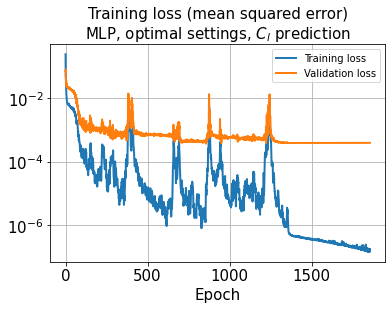

In [40]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_l$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

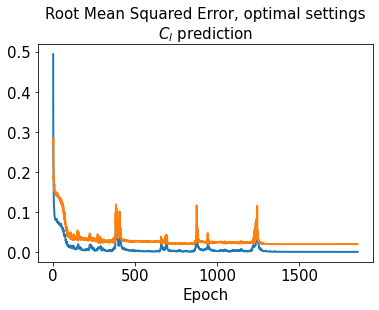

In [41]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_l$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

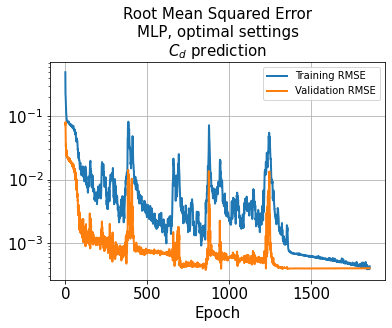

In [42]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_d$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [43]:
train_results = model.evaluate(x_train, y_train)

4/4 [==============================] - 0s 4ms/step - loss: 2.6132e-05 - rmse: 0.0051


In [44]:
test_results = model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 22ms/step - loss: 1.7446e-04 - rmse: 0.0132


In [45]:
model_directory = "D:\\TrainedModels\\20221230"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221230steady_MLP_previousSetting_test"+str(test_rate)+ "_" + str(n_units) +"units_Clonly.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [46]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [47]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [48]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cl)-np.min(cl))+np.min(cl)

In [49]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [50]:
index_train = define_index(cl, y_train)
index_val = define_index(cl, y_val)
index_test = define_index(cl, y_test)

In [51]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

1/1 [==============================] - 0s 16ms/step


In [52]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [53]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.0079909928640235
0.3422354349441629


In [54]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.026047361734657274
0.9454047832553487


In [55]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.017757554406417356
0.801672892490037


In [56]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [57]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [58]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [59]:
os.chdir(storage_dir)

In [60]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [61]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [62]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [63]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [64]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [65]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [66]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, steady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_l$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

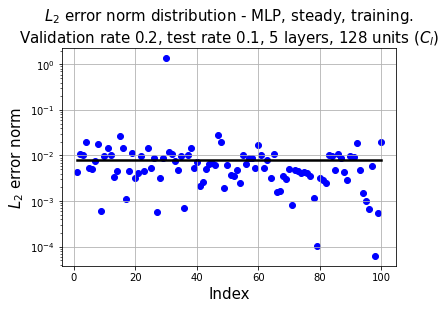

In [67]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

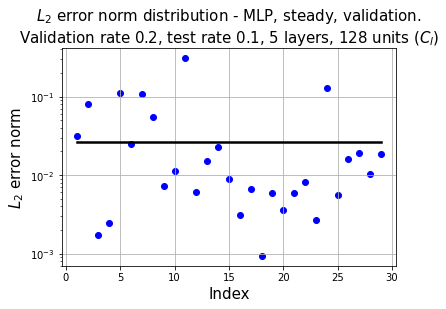

In [68]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

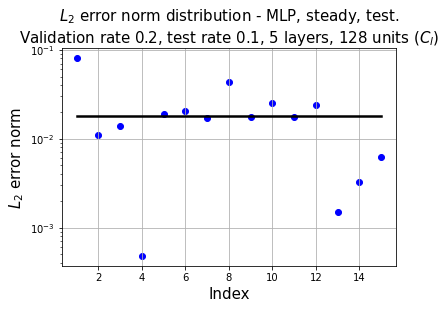

In [69]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [70]:
predicted = model.predict(x)

5/5 [==============================] - 0s 2ms/step


In [71]:
l2_error(predicted, y)

0.015136738429537775

In [72]:
l2_error(denormalize(predicted), denormalize(y))

0.015114175903185093

In [73]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [74]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [75]:
iTrain

array([[0.07829523],
       [0.20014634],
       [0.43533707],
       [0.5428147 ],
       [0.64085304],
       [0.72531959],
       [0.78388935],
       [0.79504709],
       [0.46498353],
       [0.57508838],
       [0.67395674],
       [0.75696496],
       [0.82073726],
       [0.11326874],
       [0.24039666],
       [0.36464193],
       [0.48266427],
       [0.59392803],
       [0.82894226],
       [0.83014806],
       [0.24830382],
       [0.49178494],
       [0.60378922],
       [0.70364091],
       [0.78497435],
       [0.83728118],
       [0.83620876],
       [0.12068746],
       [0.248154  ],
       [0.37238232],
       [0.60168919],
       [0.70062532],
       [0.78161168],
       [0.83380317],
       [0.17080002],
       [0.27531911],
       [0.39837455],
       [0.72053083],
       [0.8019807 ],
       [0.85555728],
       [0.8531834 ],
       [0.18051965],
       [0.31094384],
       [0.76960343],
       [0.84977043],
       [0.89760389],
       [0.33557902],
       [0.463

In [76]:
aa = aa*16

In [77]:
aa = np.ceil(aa)

In [78]:
def CL_trainTestSplit_Plot(i, CL, cl, aTrain, aVal, aTest, iTrain, iVal, iTest):
    
    #title_0_Cd = 'Gurney flap not attached (NACA0018)\n$C_D$ prediction, L2 error=%.4f' % l2_error_Cd
    title_0_Cl = 'Gurney flap not attached (NACA0018)\n$C_l$ prediction (normalized), L2 error=%.4f' % l2_error_Cl
    
    #title_n_Cd = 'Gurney flap attached h=%.2f, beta=%d\nCD prediction, L2 error=%.4f'%(h[i], beta[i],l2_error_Cd)
    title_n_Cl = 'Gurney flap attached h=%.2f, beta=%d\nCl prediction (normalized), L2 error=%.4f'%(h[i], beta[i], l2_error_Cl)
    
    if i==0:
        title_Cl = title_0_Cl
        savename1 =  "ClComparison_NACA0018.jpg"
    else:
        title_Cl = title_n_Cl
        #savename1 = "CdComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
        savename1 = "ClComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
'''
    # CD graph plot
    plt.plot(alpha, CL, 'k-', label='Ground truth')
    plt.plot(alpha, cl, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain, color='b', label='Training set')
    plt.scatter(aVal, iVal, color='g', label='Validation set')
    plt.scatter(aTest, iTest, color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_D$ (normalized)')
    plt.title(title_Cd, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([0, 1])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
'''
    # CL graph plot
    plt.plot(alpha, denormalize(CL), 'k-', label='Ground truth')
    plt.plot(alpha, denormalize(cl), 'k--', label='Predicted value')
    plt.scatter(aTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(aVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(aTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_L$ (normalized)')
    plt.title(title_Cl, fontsize=15)
    plt.legend(loc='upper left')
    plt.ylim([0, 1])
    plt.grid()
    plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()'''

IndentationError: unexpected indent (1472548039.py, line 33)

In [ ]:
h = [0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03]
beta = [0, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90]


for i in range(0, 16):
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    predictedValue = predicted[n_alpha*i:n_alpha*(i+1),:]
    y_corres = y[n_alpha*i:n_alpha*(i+1),:]
    
    #l2_error_Cd = np.sqrt(np.sum((predictedValue[:,0] - y_corres[:,0])**2) / np.sum(y_corres[:,0]**2))
    l2_error_Cl = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cd: {0:0.4f}'.format(l2_error_Cl))
    else:
        print('L2 error of Cd: {0:0.4f}'.format(l2_error_Cl))
    
    cl = predicted[n_alpha*i:n_alpha*(i+1),:]
    #cd = predicted[n_alpha*i:n_alpha*(i+1),0]/10
    
    Cl = y[n_alpha*i:n_alpha*(i+1),:]
    #CD = y[n_alpha*i:n_alpha*(i+1),0]/10
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & (index_test>=i*n_alpha))]):
        iTest_.append(predicted[index])
        
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    alpha_train = []
    alpha_val = []
    alpha_test = []
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        alpha_train.append(aa[index])
    for ii, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        alpha_val.append(aa[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & ((index_test>=i*n_alpha)))]):
        alpha_test.append(aa[index])
        
    aTrain = np.array(alpha_train)
    aVal = np.array(alpha_val)
    aTest = np.array(alpha_test)
    
    CL_trainTestSplit_Plot(i, Cl, cl, aTrain, aVal, aTest, iTrain_, iVal_, iTest_)

In [ ]:
iTrain_

In [ ]:
aa